In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

#Archivos csv disponibles en: https://drive.google.com/drive/folders/1wFX-KmmatozXpXGqMqLJKY7FIt3MUkQv?usp=sharing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/FCiencias/10. Decimo_semestre(9)/Laboratorio_Moreno/4.Ley de Paschen/datos_csv


In [ ]:
intento1 = pd.read_csv("2cm_1.csv",sep = "\t")
intento2 = pd.read_csv("2cm_2.csv",sep = "\t")
intento3 = pd.read_csv("2cm_3.csv",sep = "\t")
intento4 = pd.read_csv("15cm_1.csv",sep = "\t")
intento5 = pd.read_csv("15cm_argon_1.csv",sep = ",")
intento6 = pd.read_csv("30cm_argon_1.csv",sep = "\t")
intento7 = pd.read_csv("10cm_argon_1.csv",sep = "\t")
intento8 = pd.read_csv("2cm_argon_1.csv",sep = ",")
intento9 = pd.read_csv("30cm_aire_1.csv",sep=",")

x1 = np.array(intento1["P"],dtype = "float64")
y1 = np.array(intento1["V"],dtype = "float64")*1000

x2 = np.array(intento2["P"],dtype = "float64")
y2 = np.array(intento2["V"],dtype = "float64")

x3 = np.array(intento3["P"],dtype = "float64")
y3 = np.array(intento3["V"],dtype = "float64")

x4 = np.array(intento4["P"],dtype = "float64")
y4 = np.array(intento4["V"],dtype = "float64")

x5 = np.array(intento5["P"],dtype = "float64")
y5 = np.array(intento5["V"],dtype = "float64")

x6 = np.array(intento6["P"],dtype = "float64")
y6 = np.array(intento6["V"],dtype = "float64")

x7 = np.array(intento7["P"],dtype = "float64")
y7 = np.array(intento7["V"],dtype = "float64")

x8 = np.array(intento8["P"],dtype = "float64")
y8 = np.array(intento8["V"],dtype = "float64")

x9 = np.array(intento9["P"],dtype = "float64")
y9 = np.array(intento9["V"],dtype = "float64")

dic1 = {"1":"Aire 2cm_1",
       "2":"Aire 2cm_2",
       "3":"Aire 2cm_3",
       "4":"Aire 15cm",
       "5":"Argon 15cm",
       "6":"Argon 30cm",
       "7":"Argon 10cm",
       "8":"Argon 2cm",
       "9":"Aire 30cm"
       }
dic = {values : keys for keys, values in dic1.items()}

In [ ]:
#Función de voltaje de rompimiento (ley de Paschen)
def paschen(p,A,B,g,d):
    a = np.log(A*p*d)
    b = np.log(1+(1/g))
    c = np.log(b)

    IF = [abs(a-c)<1e-10,a-c<0]
    THEN = [5000,5000]
    return np.select(IF,THEN,default=(B*p*d)/(a-c))

#Coeficientes A y B calculados con los valores mínimos de pd y V.
def calc_AB(p,v,d,g = 0.08):
  v_min = np.min(v)
  p_min = p[np.argmin(v)]
  cg = np.log(np.log(1+(1/g)))

  B = v_min/(p_min*d)
  A = (np.e*cg)/(p_min*d)
  return A,B, p_min, v_min

#Función que calcula la incertidumbre del producto pd
def pd_err(p,d):
  dd = 0.3
  cond1 = (p<=10)
  cond2 = (p>10)&(p<=100)
  cond3 = (p>100)&(p<=1500)
  p1 = p[cond1]
  p2 = p[cond2]
  p3 = p[cond3]
  e1 = np.sqrt((d*0.3)**2+(dd*p1)**2) #+- 0.3 mTorr
  e2 = np.sqrt((d*3)**2+(dd*p2)**2)   #+- 3 mTorr
  e3 = np.sqrt((d*10)**2+(dd*p3)**2)  #+- 10 mTorr

  return np.append(np.append(e1,e2),e3)


#Función que calcula la incertidumbre del voltaje en la ley de Paschen completa
def paschen_err(p,dp,d,dd,A,B,g=0.08):
  C = np.log(np.log(1+(1/g)))
  denom = np.log(A*p*d)-C
  raiz = np.sqrt(((d*dp)**2+(dd*p)**2)/((d*p)**2))

  s1 = ((d*p)*raiz)/denom
  s2 = (d*dp)/denom
  s3 = (dd*p)/denom

  err = B*np.sqrt(s1**2+s2**2+s3**2)
  return err


#Función que grafica y regresa una tabla con los parámetros de los ajustes
#Los inputs forzosamente de tipo lista, aún cuando se ingrese un solo elemento.
def ajusta2p_gen(experimentos, \
                 distancias, \
                 colores_puntos, \
                 colores_errores, \
                 colores_ajustes, \
                 color_minimos = "red", \
                 savefig = "",
                 g = 0.08):
  popt0=[]
  popt1=[]
  r2_lista=[]
  s0=[]
  s1=[]
  A_calc = []
  B_calc = []
  for i,nombre in enumerate(experimentos):
      x = "x"+dic[nombre]
      y = "y"+dic[nombre]
      x = globals()[x]
      y = globals()[y]

      d = distancias[i]
      A ,B, p_min,v_min = calc_AB(x,y,d,g)

      A_calc +=[A]
      B_calc +=[B]

      def paschen2p(p,A,B): #Modificación de la ley de paschen para dejarla como función sólo de p y los dos parpámetros A y B
          V = paschen(p,A,B,g,d)
          IF = [V>5000]
          THEN = [max(y)]
          return np.select(IF,THEN,default=V)

      popt , pcov = curve_fit(paschen2p,x,y,bounds = (0,np.inf)) #popt = vector de parámetros, pcov = matriz de covarianza

      popt0 += [popt[0]]
      popt1 += [popt[1]]
      s0 +=[pcov[0][0]]
      s1 +=[pcov[1][1]]

      y_pred = paschen(x,*popt,g,d)
      r2=r2_score(y,y_pred)
      r2_lista += [r2]
      #print("R2 = {}".format(r2))
      x_ajuste = np.linspace(min(x),max(x),10000)
      y_pred = paschen(x_ajuste,*popt,g,d)

      y_err = np.sqrt((0.08*y)**2+10**2) #8% + 10mV*1000=8%+10V a ojo
      x_err = pd_err(x,d)

      plt.grid(color='lightgray', linestyle='dashed',zorder=1)

      plt.scatter(x*d,y,color = colores_puntos[i],s=20, zorder=2,label=nombre) #puntos experimentales

      plt.errorbar(x*d,y,xerr = x_err,yerr=y_err,ls="",ecolor = colores_errores[i],capsize = 5,zorder=0) #barras de error

      plt.plot(x_ajuste*d,y_pred,label = f"Ajuste 2 parametros {nombre}",zorder=0, color=colores_ajustes[i]) #ajuste

      plt.scatter(p_min*d,v_min,color = color_minimos ,zorder=3,s=80,marker = "1") #Punto mínimo

      plt.xlim(0,3000)
      plt.ylim(0,2000)

  #Convirtiendo a arrays para poder operar facilmente

  popt0 = np.array(popt0,dtype="float64")
  s0 = np.array(s0,dtype = "float64")
  A_calc = np.array(A_calc,dtype = "float64")
  popt1 = np.array(popt1,dtype = "float64")
  s1 = np.array(s1,dtype = "float64")
  B_calc = np.array(B_calc,dtype = "float64")
  r2_lista = np.array(r2_lista,dtype = "float64")
  sA_porc = 100*s0/popt0
  sB_porc = 100*s1/popt1

  #Redondeando a sólo 3 decimales
  popt0 = np.round(popt0,3)
  A_calc = np.round(A_calc,3)
  popt1 = np.round(popt1,3)
  B_calc = np.round(B_calc,3)
  r2_lista = np.round(r2_lista,3)


  #Haciendo el diccionario para el dataframe
  parametros = {"A[V/mTorr cm]":popt0,
                "sA":s0,
                "sA%":sA_porc,
                "A_calc":A_calc,
                "B[1/mTorr cm]":popt1,
                "sB":s1,
                "sB%":sB_porc,
                "B_calc":B_calc,
                "R2":r2_lista}

  plt.scatter(p_min*d,v_min,color = color_minimos,zorder=3,s=80,label="Mínimos",marker = "1")
  plt.xlabel("pd $[mTorr \cdot cm]$")
  plt.ylabel("V [V]")
  plt.legend()
  if savefig != "":
    plt.savefig(savefig)
  plt.show()
  df = pd.DataFrame(parametros)
  df.index = experimentos

  df2 = df[["A[V/mTorr cm]","A_calc","sA","B[1/mTorr cm]","B_calc", "sB"]].multiply(100)
  df2.columns = [["A[V/mTorr m]","A_calc","sA","B[1/mTorr m]","B_calc", "sB"]]
  df2["R2"] = df["R2"]
  df2["sA%"] = df["sA%"]
  df2["sB%"] = df["sB%"]
  return df2

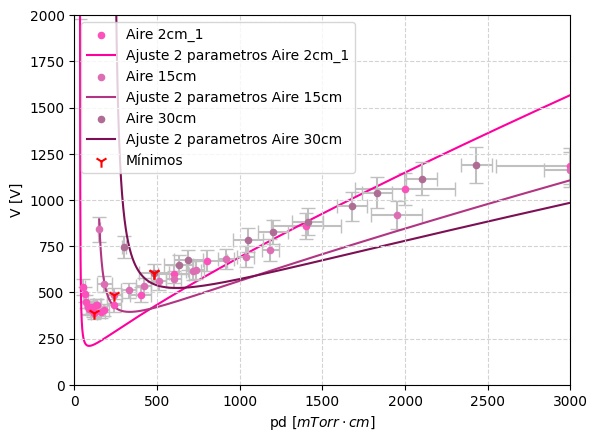

,A[V/mTorr m],A_calc,sA,B[1/mTorr m],B_calc,sB,R2,sA%,sB%
Aire 2cm_1,7.9,2.2,0.000014,236.0,325.0,3.879134,0.786,0.000174,1.643582
Aire 15cm,2.1,1.1,0.000038,117.8,201.3,0.188119,0.925,0.001795,0.159708
Aire 30cm,1.1,0.5,0.000448,84.7,126.2,1.214111,0.448,0.039199,1.434061


In [ ]:
#Todas Aire
df1 = ajusta2p_gen(experimentos = ["Aire 2cm_1","Aire 15cm" , "Aire 30cm"],
             distancias = [2,15,30],
             colores_puntos = [(252/255,80/255,187/255),(221/255,110/255,179/255),(175/255,109/255,150/255)], #colores en formato rgb =(r/255,g/255,b/255)
             colores_errores=["silver","silver","silver"],
             colores_ajustes=[(255/255,0/255,158/255),(177/255,53/255,130/255),(125/255,16/255,84/255)],
             savefig="")
df1

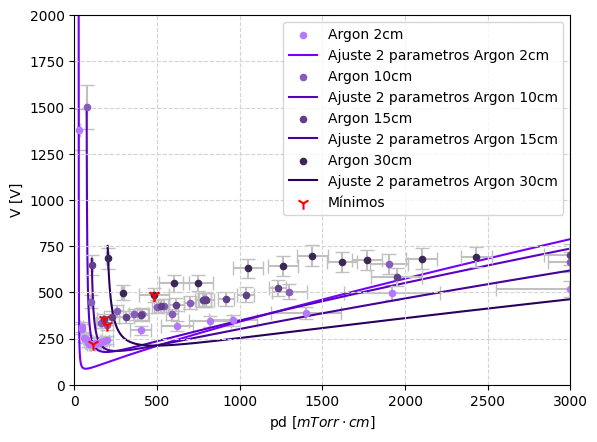

,A[V/mTorr m],A_calc,sA,B[1/mTorr m],B_calc,sB,R2,sA%,sB%
Argon 2cm,10.2,2.4,0.000138,125.3,200.0,20.487381,0.456,0.001351,16.345970
Argon 10cm,3.7,1.3,0.000006,92.0,161.0,0.753624,0.643,0.000170,0.818788
Argon 15cm,2.8,1.4,0.000081,71.4,197.2,0.421732,-0.003,0.002942,0.590805
Argon 30cm,1.5,0.5,0.000061,43.5,101.0,0.332512,-3.744,0.004187,0.764611


In [ ]:
#Todas de argón
df2= ajusta2p_gen(experimentos = ["Argon 2cm","Argon 10cm","Argon 15cm","Argon 30cm"],
             distancias = [2,10,15,30],
             colores_puntos=[(181/255, 120/255, 255/255),(136/255, 90/255, 190/255),(96/255, 64/255, 134/255),(59/255, 39/255, 83/255)],
             colores_errores=["silver","silver","silver","silver"],
             colores_ajustes=[(116/255, 0, 255/255),(89/255, 0, 194/255),(69/255, 1/255, 152/255),(42/255, 0, 93/255)],
             savefig="")
df2

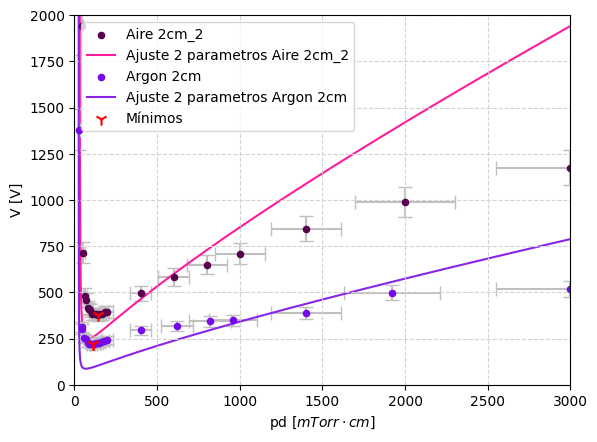

,A[V/mTorr m],A_calc,sA,B[1/mTorr m],B_calc,sB,R2,sA%,sB%
Aire 2cm_2,8.4,1.8,0.000040,295.7,266.9,28.166439,0.453,0.000476,9.526004
Argon 2cm,10.2,2.4,0.000138,125.3,200.0,20.487381,0.456,0.001351,16.345970


In [ ]:
#Aire y Argón 2cm
df3 = ajusta2p_gen(experimentos = ["Aire 2cm_2","Argon 2cm"],
             distancias = [2,2],
             colores_puntos=[(88/255,2/255,79/255),(118/255,9/255,234/255)],
             colores_errores=["silver","silver"],
             colores_ajustes=[(255/255,27/255,155/255),(137/255,36/255,232/255)],
             savefig="")
df3